In [1]:
import gesture_model
import torch
import image_dataset_loader
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

In [2]:
EPOCHS = 8
batch_size = 8

In [3]:
train_dataset, val_dataset, test_dataset = image_dataset_loader.create_datasets('new_train_data/data/', transform = True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
from sklearn import svm
t = DataLoader(train_dataset, batch_size=1000, shuffle=True)

In [25]:
for i, info in enumerate(t):
    landmarks, labels = info
    print(len(labels))
    print(landmarks.shape)
    clf = svm.LinearSVC(dual="auto")
    clf.fit(landmarks.to('cpu'), labels.to('cpu'))

85
torch.Size([85, 42])


In [29]:
for i, info in enumerate(val_loader):
    landmarks, labels = info

    print(labels[5])
    dec = clf.decision_function(landmarks.to('cpu')[5].view(1, -1))
    print(dec)
    break

tensor(1)
[[-0.79147003  0.54658324 -0.79154286 -0.86740709 -1.44872678 -1.11523049]]


tensor(4)


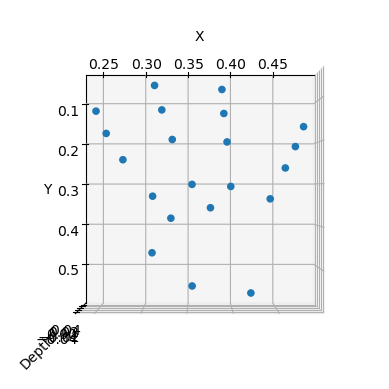

In [4]:
for i, info in enumerate(train_loader):
    landmarks, labels = info
    
    print(labels[0])
    shaped = landmarks[0].to('cpu').view(1, 21, 2)
    for i in range(shaped.shape[0]):
        x, y = zip(*shaped[i])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(x, y)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Depth')
        ax.view_init(elev=-90, azim=-90)
        plt.show()
    break

the old version processed the images every epoch causing one epoch to be:
    trained in X seconds
training on all epochs yielded an accuracy of X2


after changing it so the training dataset has pre-processed, flattened landmarks, one epoch only:
    takes Y seconds
and yielded an accuracy of Y2

this is a Z% improvement

In [5]:
torch.set_default_dtype(torch.float32)
model = gesture_model.GestureModel(6)
model = model.float().to('cuda')

for param in model.parameters():
    if param.dtype != torch.float32:
        print(f"Found a tensor with dtype {param.dtype}")

x = torch.randn(2, 42).float().to('cuda')
output = model(x)
assert output.shape == torch.Size((2, 6)), 'the output shape is wrong ' + str(output.shape)

print(f'In {x.shape} Out {output.shape}')

In torch.Size([2, 42]) Out torch.Size([2, 6])


In [6]:
torch.set_default_dtype(torch.float32)
model = gesture_model.GestureModel(6)
model = model.float().to('cuda')
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001, momentum=.9)

In [7]:
def train_model_one_epoch():
    epoch_loss = 0.
    debug_print_loss = 0.
    total_accuracy = 0
    total_f1 = 0
    total_samples = 0

    for i, data in enumerate(train_loader):
        img_path, label = data

        label = label.to('cuda')

        optimizer.zero_grad()
    
        # flattened = torch.from_numpy(image_dataset_loader.process_image(img_path, label, True)).to(torch.float32).to('cuda')
        # print(data)
        forward = model(img_path.to('cuda'))

        cur_loss = loss(forward, label)
        cur_loss.backward()

        epoch_loss += cur_loss.item()
        if i % 5 == 0:
            debug_print_loss = epoch_loss / 10
            epoch_loss = 0
            print('  batch {} loss {}'.format(i + 1, debug_print_loss))
        total_accuracy += accuracy(forward, label) * label.size(0)
        total_f1 += compute_f1(forward, label) * label.size(0)
        total_samples += label.size(0)
    
    epoch_accuracy = total_accuracy / total_samples
    epoch_f1 = total_f1 / total_samples
    print(f"Epoch Accuracy: {epoch_accuracy:.4f}, Epoch F1: {epoch_f1:.4f}")
    return debug_print_loss

In [8]:
from sklearn.metrics import f1_score
def accuracy(output, target):
    """Compute the accuracy for the current batch."""
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

def compute_f1(output, target):
    """Compute the F1 score for the current batch."""
    _, predicted = torch.max(output, 1)
    predicted = predicted.detach().cpu().numpy()
    target = target.cpu().numpy()
    return f1_score(target, predicted, average='macro')  # 'macro' can be replaced by 'micro' or 'weighted' based on preference

In [9]:
cur_epoch = 0
best_val_loss = 1_000_000
writer = SummaryWriter()

for epoch in range(EPOCHS):
    print(f'EPOCH {cur_epoch + 1}')

    model.train(True)
    epoch_loss = train_model_one_epoch()

    running_val_loss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to('cuda')
            vlabels = vlabels.to('cuda')
            voutputs = model(vinputs)
            voutputs = voutputs.to('cuda')
            vloss = loss(voutputs, vlabels)
            running_val_loss += vloss
    
    avg_vloss = running_val_loss / (i + 1)
    print(f'(LOSS) EPOCH {epoch}: train {epoch_loss} val {avg_vloss}')
    writer.add_scalar('training loss', epoch_loss, epoch * len(train_loader) + i)

    if avg_vloss < best_val_loss:
        best_val_loss = avg_vloss
        model_path = f'models/model_1_{epoch}'
    cur_epoch += 1
writer.close()

EPOCH 1
  batch 1 loss 0.1813941478729248
  batch 6 loss 0.8855290293693543
  batch 11 loss 0.9841973066329956
Epoch Accuracy: 0.3176, Epoch F1: 0.2687
(LOSS) EPOCH 0: train 0.9841973066329956 val 1.8545644283294678
EPOCH 2
  batch 1 loss 0.2211763858795166
  batch 6 loss 0.8734699249267578
  batch 11 loss 0.8128756999969482
Epoch Accuracy: 0.2706, Epoch F1: 0.2277
(LOSS) EPOCH 1: train 0.8128756999969482 val 1.8813810348510742
EPOCH 3
  batch 1 loss 0.17034339904785156
  batch 6 loss 0.9325485348701477
  batch 11 loss 0.8400099039077759
Epoch Accuracy: 0.2118, Epoch F1: 0.1563
(LOSS) EPOCH 2: train 0.8400099039077759 val 1.8573596477508545
EPOCH 4
  batch 1 loss 0.18463777303695678
  batch 6 loss 0.9066697359085083
  batch 11 loss 0.8720992803573608
Epoch Accuracy: 0.2118, Epoch F1: 0.1590
(LOSS) EPOCH 3: train 0.8720992803573608 val 1.8447822332382202
EPOCH 5
  batch 1 loss 0.11950055360794068
  batch 6 loss 0.9587306976318359
  batch 11 loss 0.8807135343551635
Epoch Accuracy: 0.2353

KeyboardInterrupt: 

In [ ]:
for ind, info in enumerate(val_dataset):
    path, lab = info

    print(lab)
    y_pred = model(path.reshape((1, 42)))
    # print(path)
    print(torch.nn.functional.softmax(y_pred, dim=1))